NOAA (1) defines an el nino as when "monthly sea surface temperatures in the central and eastern tropical Pacific Ocean (Nino 3.4 region) need to warm +0.5° Celsius above normal, with the expectation that the warming will persist for five consecutive overlapping three month periods." By contrast, UCAR (2) defines an el nino to be when "the  Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more."

1. https://www.noaa.gov/understanding-el-nino
2. https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni

NOAA's index is called the Nino 3.4 index. UCAR's index is called the ONI. The Nino 3.4 is the 3 month running average monthly SST anomalies, and the ONI is the 5 month running average monthly SST anomalies. In this way, the ONI seems more conservative about declaring whether an El Nino has occured or not.

In [230]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import copy
from datetime import date
import seaborn as sb

In [14]:
def X_step_avg(data, X):
    '''
    Takes in time series `data` and returns the X-step running average, stopping once there are no more X-step blocks of data remaining.
    In an input array of length N, there are N-X+1 blocks of size X, so the output list has length N-X+1.

    Inputs
    ----------
    data: array-like
        Time-series data
    X: int

    Returns
    ---------
    data_avg: array-like
        X-step running average of `data`
    '''
    N = len(data)
    assert(X <= N), "X must be less than the length of `data`"

    # copy() so as to avoid overwriting `data` (idk why it does it)
    data_avg = copy(data[:N-X+1])
    for i in range(N-X+1):
        data_avg[i] = (sum(data[i:i+X])/X)
    return data_avg

In [15]:
def block(bool_array, block_size):
    '''
    Takes in a 1d boolean array and returns a boolean array of the same size whose i-th entry is true if the i-th entry of the input array is true and occurs
    in a block of more than block_size other trues.
    
    Inputs:
    -----------
    bool_array: list-like, indexable
    block_size: int
    
    Returns:
    -----------
    blocked_array: list-like
    
    Examples:
    -----------
    >>> block([True, False, True, True, True, False, False, True], 2)
    [False, False, True, True, True, False, False, False]
    '''
    # append false to make sure while loop runs one more time at the end
    bool_array = list(bool_array)
    bool_array.append(False) 
    N = len(bool_array)
    i, j = 0, 0
    while i < N:
        # if at the end of a block or in between blocks, increment i and reset j
        if (bool_array[i] == False) and (j==0 or j>=block_size):
            i += 1
            j = 0
        # if at the end of a block, and the previous were true but less than block size, set all to false and increment i
        elif (bool_array[i] == False) and (0<j<block_size):
            for k in range(1,j+1):
                bool_array[i-k] = False
            i+=1
            j=0
        # if the current is true and not the last element, increment i and j
        else:
            i+= 1
            j+= 1
    
    bool_array.pop() # remove the last false
    return bool_array

In [121]:
years, months, nino34 = np.loadtxt('../Data/detrend.nino34.ascii.txt', dtype={'names': (
    'year', 'months', 'nino34'), 'formats': ('int', 'int', 'float')}, skiprows=1, usecols=(0, 1, 4), unpack=True)

In [122]:
dates = []
for (y,m) in zip(years, months):
    dates.append(date(y,m,1))
#cut off 1950
dates_new = dates[12:]

   # SOI
  

In [19]:
# from 1951-01-01 to 2020-02-01
soi = np.loadtxt("../Data/soi.txt", skiprows=88,
                 max_rows=70, usecols=np.arange(1, 13))
# each column is a month jan-dec, so flatten to get 1-d list of all dates
soi = np.ravel(soi)
# get rid of first year and last 10 months are nonsense
soi = soi[:-11]

# generate mask for El Nino months
soi_nino = soi > 1

# Smoothed SOI

In [46]:
# the soi is quite variable, so let's take a running average to smooth it out
soi_smooth = X_step_avg(soi, 3)
soi_smooth_nino = soi_smooth > 1

# ONI

In [27]:
# calculate ONI from Nino3.4 and round to 2 decimal places
oni_calculated = np.round(X_step_avg(nino34, 3), 2)
oni_noaa = np.loadtxt('../Data/oni.ascii.txt', skiprows=2, usecols=(3))

Is my ONI the same as NOAA's?

In [28]:
np.sum(1-np.isclose(oni_calculated, oni_noaa, rtol=0, atol=.05))

0

Yes. That means X_step_avg is working correctly, and that I understand the def of ONI. Now loet's figure out which dates are el nino.

In [29]:
oni_calculated = oni_calculated[12:]
dates_trimmed = np.array(dates_new[:len(oni_calculated)])
oni_where_is_nino = block(oni_calculated > .5, 5)
oni_nino = dates_trimmed[oni_where_is_nino]

# Nino 3.4 Index (UCAR)

In [32]:
nino34idx = np.round(X_step_avg(nino34, 5), 2)
nino34idx = nino34idx[12:]

In [33]:
dates_trimmed = np.array(dates_new[:len(nino34idx)])
nino34idx_where_is_nino = block(nino34idx > .5, 6)
nino34idx_nino = dates_trimmed[nino34idx_where_is_nino ]

# Comparison

In [ ]:
plt.plot_date()

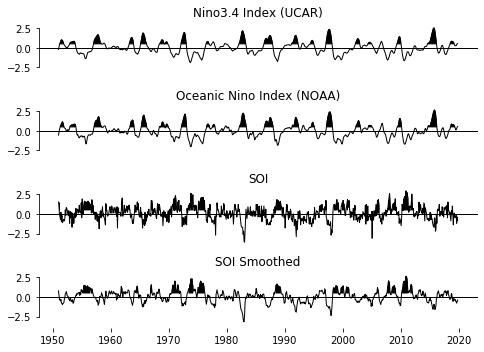

In [107]:
fig, AX = plt.subplots(nrows=4, ncols=1, sharex=False, sharey=True, facecolor='white',figsize=(7,5))

minlen = min(len(nino34idx), len(oni_calculated),len(soi_nino), len(soi_smooth))

# plot indices
AX[0].plot(dates_new[:minlen], nino34idx[:minlen], '-', color='black', alpha=1,label='Nino3.4',lw=1)
AX[1].plot(dates_new[:minlen], oni_calculated[:minlen],'-', color='black', alpha=1,label='ONI',lw=1)
AX[2].plot(dates_new[:minlen], soi[:minlen],'-', color='black', alpha=1,label='SOI',lw=1)
AX[3].plot(dates_new[:minlen], soi_smooth[:minlen],'-', color='black', alpha=1,label='SOI Smoothed',lw=1)
for i in range(4):
    AX[i].axhline(color='black',lw=1)

# plot ninos
AX[0].fill_between(dates_new[:minlen], .5, nino34idx[:minlen], where=(nino34idx_where_is_nino[:minlen]) ,color='black', alpha=1)
AX[1].fill_between(dates_new[:minlen], .5, oni_calculated[:minlen], where=(oni_where_is_nino[:minlen]) ,color='black', alpha=1)
AX[2].fill_between(dates_new[:minlen], .5, soi[:minlen], where=(soi_nino[:minlen]) ,color='black', alpha=1)
AX[3].fill_between(dates_new[:minlen], .5, soi_smooth[:minlen], where=(soi_smooth_nino[:minlen]) ,color='black', alpha=1)

# labels and clean up
AX[0].set_title('Nino3.4 Index (UCAR)')
AX[1].set_title('Oceanic Nino Index (NOAA)')
AX[2].set_title('SOI')
AX[3].set_title('SOI Smoothed')

sb.despine(top=True, bottom=True, right=True, trim=True)
for ax in AX[:-1]:
    ax.set_xticks([])
fig.tight_layout()
AX[-1].xaxis_date()

# save
#plt.savefig('/home/samserra/Projects/ComplexNetworksAndClimateScience/Output/Images/NinoDefComparison.jpg',dpi=300)

As we see, the ONI and Nino3.4 index are very similar, except that the ONI is more variable than the nino3.4 since it is averaged over only 3 months compared to nino3.4's 5 months. However, the SOI is very different from either of the other indices.

# Create list of dates for el nino/la nina in text file

In [231]:
# in the output file, there will be 3 columns: a list of dates (year then month) and an elnino/lanina/normal indicator
# for the indicator: 1=elnio, -1=lanina, 0=neither
nino34idx = np.round(X_step_avg(nino34, 5), 2)
ninos = np.array(block(nino34idx > .5, 6)).astype('int')
ninas = np.array(block(nino34idx < -.5, 6)).astype('int')
indicator = ninos-ninas

dates = dates
dates = dates[:len(nino34idx)]

years, months = [], []
for d in dates:
    years.append(d.year)
    months.append(d.month)
years, months = np.array(years), np.array(months)

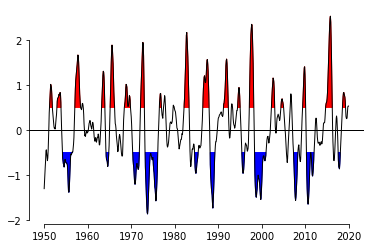

In [228]:
## run a test plot
fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='white')#,figsize=(7,5))

# plot indices
ax.plot(dates, nino34idx, '-', color='black', alpha=1,label='Nino3.4',lw=1)
ax.axhline(color='black',lw=1)

# plot ninos
ax.fill_between(dates, .5, nino34idx, where=ninos, color='red', alpha=1)
ax.fill_between(dates, -.5, nino34idx, where=ninas, color='blue', alpha=1)

# beautify
sb.despine(trim=True)
ax.xaxis_date()

In [259]:
with open('/home/samserra/Projects/ComplexNetworksAndClimateScience/Data/nino34idxDates.txt','w') as f:
    f.write('Year Month Indicator\n')
    for ln in range(len(dates)):
        f.write('{:4n} {:5n} {:9n}\n'.format(years[ln], months[ln], indicator[ln]))

In [270]:
# to read in again
#np.loadtxt('/home/samserra/Projects/ComplexNetworksAndClimateScience/Data/nino34idxDates.txt', dtype='str', skiprows=1)